<a href="https://www.kaggle.com/code/anshv2/skin-cancer-cnn?scriptVersionId=116960417" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import and Data Augmentation

In [7]:
#importing 
#importing 
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator as data_augment
from keras.models import Model,Sequential
from keras.layers import Input,Conv2D,MaxPooling2D,Dropout,Flatten,Dense,GlobalAveragePooling2D,BatchNormalization
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras import layers as layers
from keras.layers.merge import concatenate
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet169
import matplotlib.pyplot as plt

#data augmetation 
data_generate_training = data_augment (rescale=1./255, 
                              shear_range = 0.2,
                              zoom_range = 0.2,
                              fill_mode = "nearest",
                              horizontal_flip = True,
                              width_shift_range = 0.2,
                              height_shift_range = 0.2,)

data_generate_test = data_augment(rescale = 1./255)

#data preprocessing and augmentation
traind = data_generate_training.flow_from_directory("../input/skin-cancer-malignant-vs-benign/train",
                                          target_size = (224, 244),
                                          class_mode = 'binary',
                                          seed = 123,
                                          batch_size = 32,
                                          shuffle = True)

testd = data_generate_training.flow_from_directory("../input/skin-cancer-malignant-vs-benign/test",
                                          target_size = (224, 244),
                                          class_mode = 'binary',
                                          seed = 123,
                                          batch_size = 32,
                                          shuffle = True)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


# Model Architecture

In [8]:
#Building pre-trained model
mobilenet_base = MobileNetV2(weights = 'imagenet', input_shape = (224, 224, 3), include_top = False)
densenet_base = DenseNet169(weights = 'imagenet', input_shape = (224, 224, 3), include_top = False)

for layer in mobilenet_base.layers:
    layers.trainable = False
for layer in densenet_base.layers:
    layer.trainable = False
    
input_shape = (224,224,3)
input_layer = Input(shape = (224, 224, 3))
#first model
mobilenet_base = MobileNetV2(weights = 'imagenet',input_shape = input_shape,include_top = False)
densenet_base = DenseNet169(weights = 'imagenet', input_shape = input_shape,include_top = False)
for layer in mobilenet_base.layers:
    layer.trainable =  False
for layer in densenet_base.layers:
    layer.trainable = False
    
model_mobilenet = mobilenet_base(input_layer)
model_mobilenet = GlobalAveragePooling2D()(model_mobilenet)
output_mobilenet = Flatten()(model_mobilenet)
model_densenet = densenet_base(input_layer)
model_densenet = GlobalAveragePooling2D()(model_densenet)
output_densenet = Flatten()(model_densenet)

merged = tf.keras.layers.Concatenate()([output_mobilenet, output_densenet])

In [9]:
#Building Model
x = BatchNormalization()(merged)
x = Dense(256,activation = 'relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128,activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation = 'sigmoid')(x)
CNNmodel = tf.keras.models.Model(inputs = input_layer, outputs = x)


# Callbacks

In [10]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
EarlyStopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.01,
                              patience=6,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.01,
                            patience=6,
                            verbose=0,
                            mode="max",
                            min_delta=0.01)


# Training

In [11]:
nb_train_samples = 2637 # number of training-samples
nb_validation_samples = 660 # number of validation-samples
nb_test_samples = 624 # number of training-samples
epochs = 20  
batch_size  = 16

optm = tf.keras.optimizers.Adam(learning_rate=0.0001)
CNNmodel.compile(optimizer = optm,
              loss="binary_crossentropy",
              metrics=['accuracy'])

history = CNNmodel.fit(traind,
                      epochs = 20, validation_data = testd, callbacks = [EarlyStopping, rlr])

Epoch 1/20
83/83 [==============================] - 294s 3s/step - loss: 0.7459 - accuracy: 0.6295 - val_loss: 0.5005 - val_accuracy: 0.7758
Epoch 2/20
83/83 [==============================] - 281s 3s/step - loss: 0.5539 - accuracy: 0.7421 - val_loss: 0.4043 - val_accuracy: 0.8152
Epoch 3/20
83/83 [==============================] - 283s 3s/step - loss: 0.4944 - accuracy: 0.7732 - val_loss: 0.3764 - val_accuracy: 0.8485
Epoch 4/20
83/83 [==============================] - 282s 3s/step - loss: 0.4544 - accuracy: 0.7971 - val_loss: 0.3393 - val_accuracy: 0.8455
Epoch 5/20
83/83 [==============================] - 277s 3s/step - loss: 0.4480 - accuracy: 0.8032 - val_loss: 0.3320 - val_accuracy: 0.8591
Epoch 6/20
83/83 [==============================] - 282s 3s/step - loss: 0.4230 - accuracy: 0.8138 - val_loss: 0.3362 - val_accuracy: 0.8545
Epoch 7/20
83/83 [==============================] - 285s 3s/step - loss: 0.4045 - accuracy: 0.8229 - val_loss: 0.3151 - val_accuracy: 0.8515
Epoch 8/20
83

# Model Evaluation

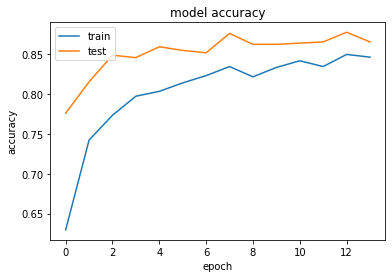

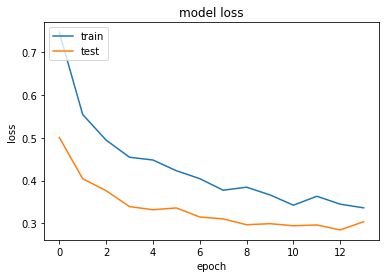

In [13]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()